[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\filip\AppData\Local\Temp\


Asset Allocation and Clusters:
         Weight  Cluster
O        0.0653        3
COST     0.0841        3
META     0.0339        2
BTC-USD  0.0446        1
MSTR     0.0346        1
WMT      0.0902        3
MVUS.MI  0.1303        3
EGLN.L   0.2150        1
QQQ      0.0591        2
RACE     0.0505        2
UBER     0.0273        2
ORLY     0.0728        3
PEP      0.0925        3

Performance Metrics:
               Annualized Return  Annualized Volatility  Sharpe Ratio  \
HRC Portfolio             0.2261                 0.1503        1.5048   
URTH                      0.1373                 0.1978        0.6943   

               Max Drawdown  
HRC Portfolio       -0.2216  
URTH                -0.3401  

Risk Metrics:
              Metric   Value
0               Beta  0.6493
1     Tracking Error  0.1046
2  Information Ratio  0.8490


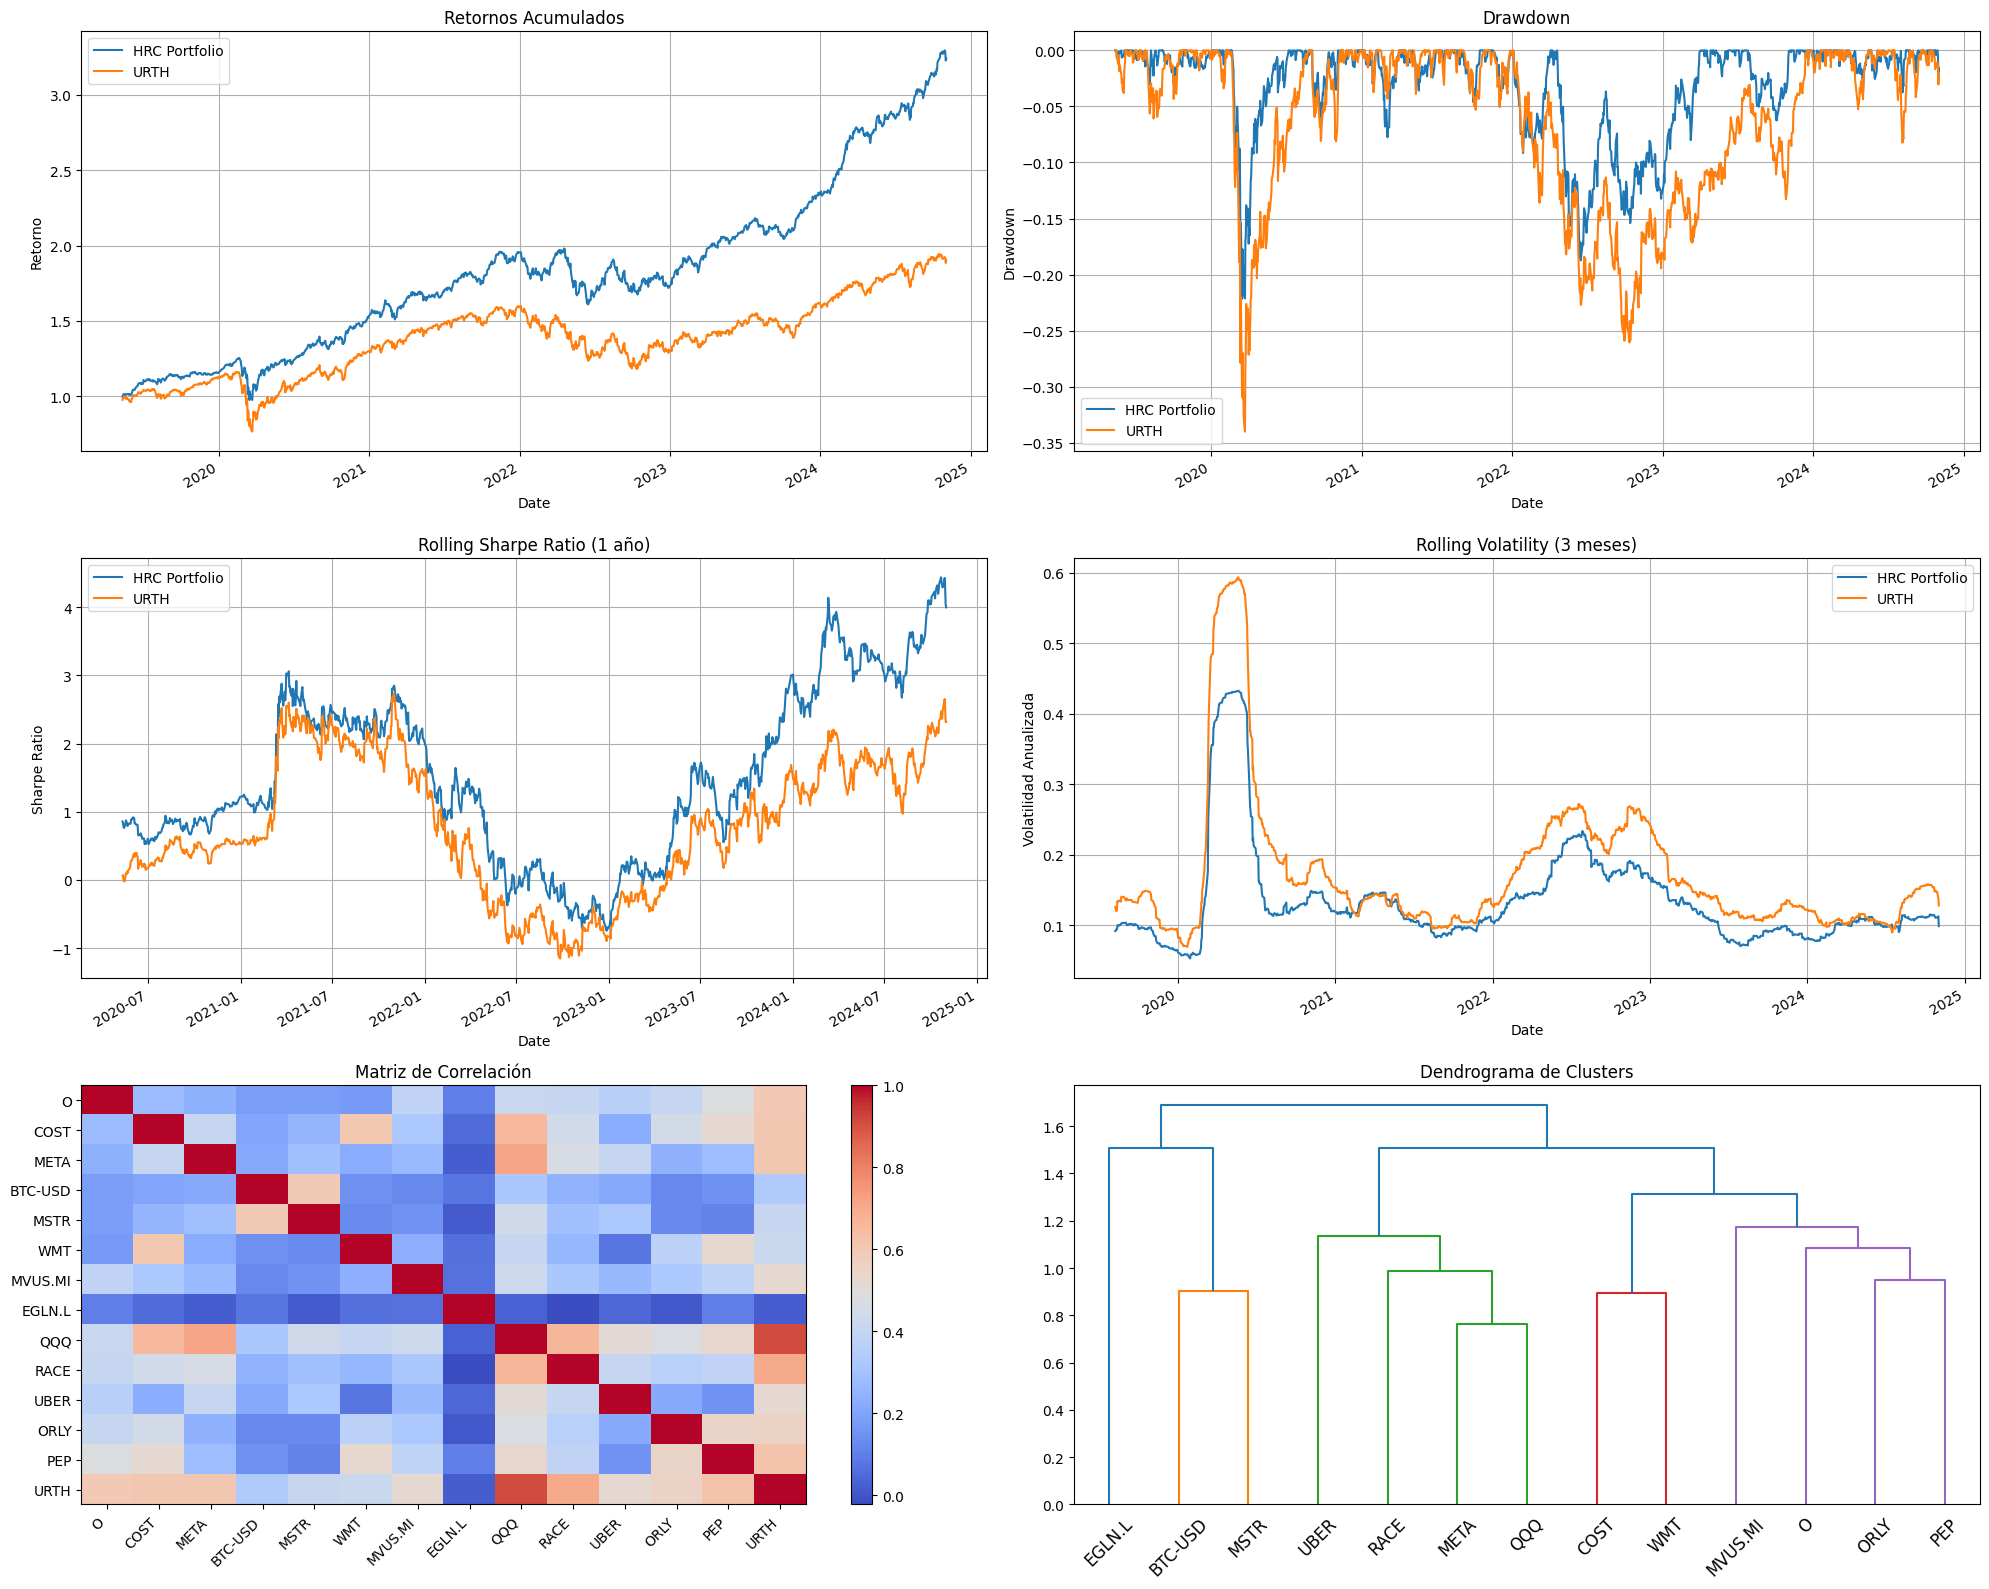

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Configuración de estilo básico para los gráficos
plt.style.use('default')

# Configuración inicial
end_date = datetime.now()
start_date = end_date - timedelta(days=3650)  # 10 años

def get_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for ticker in tickers:
        try:
            stock = yf.download(ticker, start=start_date, end=end_date)['Adj Close']
            data[ticker] = stock
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
    return data.fillna(method='ffill')

# Obtener datos
assets = ['O', 'COST', 'META', 'BTC-USD', 'MSTR', 'WMT', 'MVUS.MI', 'EGLN.L','QQQ','RACE','UBER','ORLY',"PEP"]
benchmark = 'URTH'

# Descargar datos
prices = get_data(assets + [benchmark], start_date, end_date)
returns = prices.pct_change().dropna()

class EnhancedHRC:
    def __init__(self, returns, linkage_method='ward'):
        self.returns = returns
        self.cov_matrix = returns.cov() * 252
        self.corr_matrix = returns.corr()
        self.linkage_method = linkage_method

    def compute_distance_matrix(self):
        dist = np.sqrt(2 * (1 - self.corr_matrix))
        return dist

    def build_hierarchy(self):
        dist_matrix = self.compute_distance_matrix()
        dist_condensed = []
        n = len(dist_matrix)
        for i in range(n):
            for j in range(i + 1, n):
                dist_condensed.append(dist_matrix.iloc[i, j])

        self.linkage_matrix = linkage(dist_condensed, method=self.linkage_method)
        return self.linkage_matrix

    def optimize_portfolio(self, n_clusters=3):
        if not hasattr(self, 'linkage_matrix'):
            self.build_hierarchy()

        from scipy.cluster.hierarchy import fcluster
        clusters = fcluster(self.linkage_matrix, n_clusters, criterion='maxclust')
        cluster_labels = pd.Series(clusters, index=self.returns.columns)

        final_weights = pd.Series(0, index=self.returns.columns)
        cluster_vars = []

        for cluster in range(1, n_clusters + 1):
            assets = cluster_labels[cluster_labels == cluster].index
            if len(assets) > 0:
                cluster_cov = self.cov_matrix.loc[assets, assets]
                ivols = 1/np.sqrt(np.diag(cluster_cov))
                weights = ivols/sum(ivols)
                final_weights[assets] = weights

                cluster_var = np.dot(np.dot(weights, cluster_cov), weights)
                cluster_vars.append(cluster_var)

        cluster_vars = np.array(cluster_vars)
        cluster_weights = 1/cluster_vars
        cluster_weights = cluster_weights/sum(cluster_weights)

        for i, cluster in enumerate(range(1, n_clusters + 1)):
            assets = cluster_labels[cluster_labels == cluster].index
            final_weights[assets] *= cluster_weights[i]

        return final_weights, cluster_labels

# Crear y optimizar portafolio
hrc = EnhancedHRC(returns.drop(benchmark, axis=1))
weights, clusters = hrc.optimize_portfolio(n_clusters=3)

# Calcular rendimientos del portafolio
portfolio_returns = (returns.drop(benchmark, axis=1) * weights).sum(axis=1)
benchmark_returns = returns[benchmark]

# Función para calcular drawdown
def calculate_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown

# Función para calcular Sharpe ratio móvil
def rolling_sharpe(returns, window=252, risk_free_rate=0.02):
    excess_returns = returns - risk_free_rate/252
    rolling_mean = excess_returns.rolling(window=window).mean() * 252
    rolling_std = returns.rolling(window=window).std() * np.sqrt(252)
    return rolling_mean / rolling_std

# Calcular métricas
cumulative_returns = pd.DataFrame({
    'HRC Portfolio': (1 + portfolio_returns).cumprod(),
    'URTH': (1 + benchmark_returns).cumprod()
})

drawdowns = pd.DataFrame({
    'HRC Portfolio': calculate_drawdown(portfolio_returns),
    'URTH': calculate_drawdown(benchmark_returns)
})

rolling_sharpes = pd.DataFrame({
    'HRC Portfolio': rolling_sharpe(portfolio_returns),
    'URTH': rolling_sharpe(benchmark_returns)
})

# Calcular volatilidad móvil
rolling_vol = pd.DataFrame({
    'HRC Portfolio': returns.drop(benchmark, axis=1).mul(weights).sum(axis=1).rolling(window=63).std() * np.sqrt(252),
    'URTH': returns[benchmark].rolling(window=63).std() * np.sqrt(252)
})

# Crear visualizaciones
fig = plt.figure(figsize=(20, 16))

# 1. Retornos Acumulados
ax1 = plt.subplot(3, 2, 1)
cumulative_returns.plot(ax=ax1)
ax1.set_title('Retornos Acumulados')
ax1.set_ylabel('Retorno')
ax1.grid(True)

# 2. Drawdown
ax2 = plt.subplot(3, 2, 2)
drawdowns.plot(ax=ax2)
ax2.set_title('Drawdown')
ax2.set_ylabel('Drawdown')
ax2.grid(True)

# 3. Rolling Sharpe
ax3 = plt.subplot(3, 2, 3)
rolling_sharpes.plot(ax=ax3)
ax3.set_title('Rolling Sharpe Ratio (1 año)')
ax3.set_ylabel('Sharpe Ratio')
ax3.grid(True)

# 4. Rolling Volatility
ax4 = plt.subplot(3, 2, 4)
rolling_vol.plot(ax=ax4)
ax4.set_title('Rolling Volatility (3 meses)')
ax4.set_ylabel('Volatilidad Anualizada')
ax4.grid(True)

# 5. Correlation Matrix plot
ax5 = plt.subplot(3, 2, 5)
im = ax5.imshow(returns.corr(), cmap='coolwarm', aspect='auto')
plt.colorbar(im)
ax5.set_xticks(range(len(returns.columns)))
ax5.set_yticks(range(len(returns.columns)))
ax5.set_xticklabels(returns.columns, rotation=45, ha='right')
ax5.set_yticklabels(returns.columns)
ax5.set_title('Matriz de Correlación')

# 6. Cluster Dendrogram
ax6 = plt.subplot(3, 2, 6)
dendrogram(hrc.linkage_matrix, labels=returns.drop(benchmark, axis=1).columns, ax=ax6)
ax6.set_title('Dendrograma de Clusters')
plt.xticks(rotation=45)

plt.tight_layout()

# Calcular y mostrar estadísticas
stats = pd.DataFrame({
    'Weight': weights,
    'Cluster': clusters
}).round(4)

print("\nAsset Allocation and Clusters:")
print(stats)

# Calcular métricas de rendimiento
annualized_return = {
    'HRC Portfolio': portfolio_returns.mean() * 252,
    'URTH': benchmark_returns.mean() * 252
}

annualized_vol = {
    'HRC Portfolio': portfolio_returns.std() * np.sqrt(252),
    'URTH': benchmark_returns.std() * np.sqrt(252)
}

sharpe_ratio = {
    'HRC Portfolio': annualized_return['HRC Portfolio'] / annualized_vol['HRC Portfolio'],
    'URTH': annualized_return['URTH'] / annualized_vol['URTH']
}

max_drawdown = {
    'HRC Portfolio': drawdowns['HRC Portfolio'].min(),
    'URTH': drawdowns['URTH'].min()
}

performance_metrics = pd.DataFrame({
    'Annualized Return': annualized_return,
    'Annualized Volatility': annualized_vol,
    'Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown
}).round(4)

print("\nPerformance Metrics:")
print(performance_metrics)

# Calcular beta y tracking error
portfolio_excess_returns = portfolio_returns - returns[benchmark]
tracking_error = portfolio_excess_returns.std() * np.sqrt(252)

beta = np.cov(portfolio_returns, benchmark_returns)[0,1] / np.var(benchmark_returns)

information_ratio = (portfolio_returns.mean() - benchmark_returns.mean()) * 252 / tracking_error

risk_metrics = pd.DataFrame({
    'Metric': ['Beta', 'Tracking Error', 'Information Ratio'],
    'Value': [beta, tracking_error, information_ratio]
}).round(4)

print("\nRisk Metrics:")
print(risk_metrics)